# <center> Stroke Prediction </center>
#### <center> Zach Hanson </center>

## Project Description


### Task

- Create the most optimal model for predicting if a person is at risk for a stroke based on various health and environment related factors.

### Data Dictionary

**Variable Name** | **Description**
--- | ---
Gender | Whether the person was male, female, or other
Age | Age of patient
hypertension | Whether or not the patient has hypertension: 0 for no, 1 for yes
heart_disease | Whether or not the patient has a heart disease: 0 for no, 1 for yes
ever_married | Whether or not the patient was ever married
work_type | Type of work the patient was involved in (children, government job, self-employed, never worked, or private)
Residence_type | Whether the patient lived in Rural or Urban area
avg_glucose_level | Average glucose level of the patient
bmi | Body Mass Index of patient
smoking_status | If the patient currently smokes, formerly smoked, never smoked, or unknown

## Import Libraries and Data

### Libraries

In [1]:
#Pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Seaborn for better visual on graphs
import seaborn as sns
#Default theme as seaborn
sns.set_theme()

#Imputer
from sklearn.impute import SimpleImputer

#Transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#GridSearchCV for tuning models
from sklearn.model_selection import GridSearchCV

#Evaluation Metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#PCA
from sklearn.decomposition import PCA

#Hiding Warnings (Added after finishing all code)
import warnings
warnings.simplefilter("ignore")

#Setting global SciKit-Learn Configuration
#Easier to visualize pipelines
from sklearn import set_config
set_config(display='diagram')

### Data

In [2]:
#Loading in data
filename = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(filename)

In [3]:
#Checking to see if loaded properly
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Looks to be loaded properly

In [4]:
df.shape

(5110, 12)

### Functions

In [5]:
def convert_probs_to_preds(probabilities, threshold, pos_class=1):
  """Converts float value probabilities into int value predictions.
  #If the probability of class 1 is greater than the threshold, the prediction is 1
  #Otherwise the prediction is 0
  pos_class determines the index of the positive class in the array of probabilies"""
  predictions = [1 if prob[pos_class] > threshold else 0 for prob in probabilities]
  return predictions

def eval_classification(true, pred, name='Model'):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""
  
    print(name, '\n')
    print(classification_report(true, pred))
    ConfusionMatrixDisplay.from_predictions(true, pred, cmap='Blues')
    plt.grid(False)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

## Data Cleaning

### Removing Unnecessary Columns

In [6]:
df = df.drop(columns = 'id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- ID column was dropped successfully
  - This column is not important to predicting stroke risk as each identifier will be different

### Removing Unnecessary Rows

In [7]:
duprow = df.duplicated().sum()
print(f"There are {duprow} duplicated rows.")

There are 0 duplicated rows.


### Missing Values

In [8]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- The only missing values in this data set are in the "bmi" column.
- This will be addressed later using an imputer during our model creations.

### Inconsistencies in Data

#### Gender

In [9]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

- No inconsistencies in this column.

#### Ever Married

In [10]:
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

- No inconsistencies in this column.

#### Work Type

In [11]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

- No inconsistencies in this column.

#### Residence Type

In [12]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

- No inconsistencies in this column.

#### Smoking Status

In [13]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

- No inconsistencies in this column.

## Exploratory Analysis

In [14]:
#Copying data frame to prevent data leakage
ea_df = df.copy()

#Checking to see if it copied correctly
ea_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Looks to be copied correctly

### Categorical Features

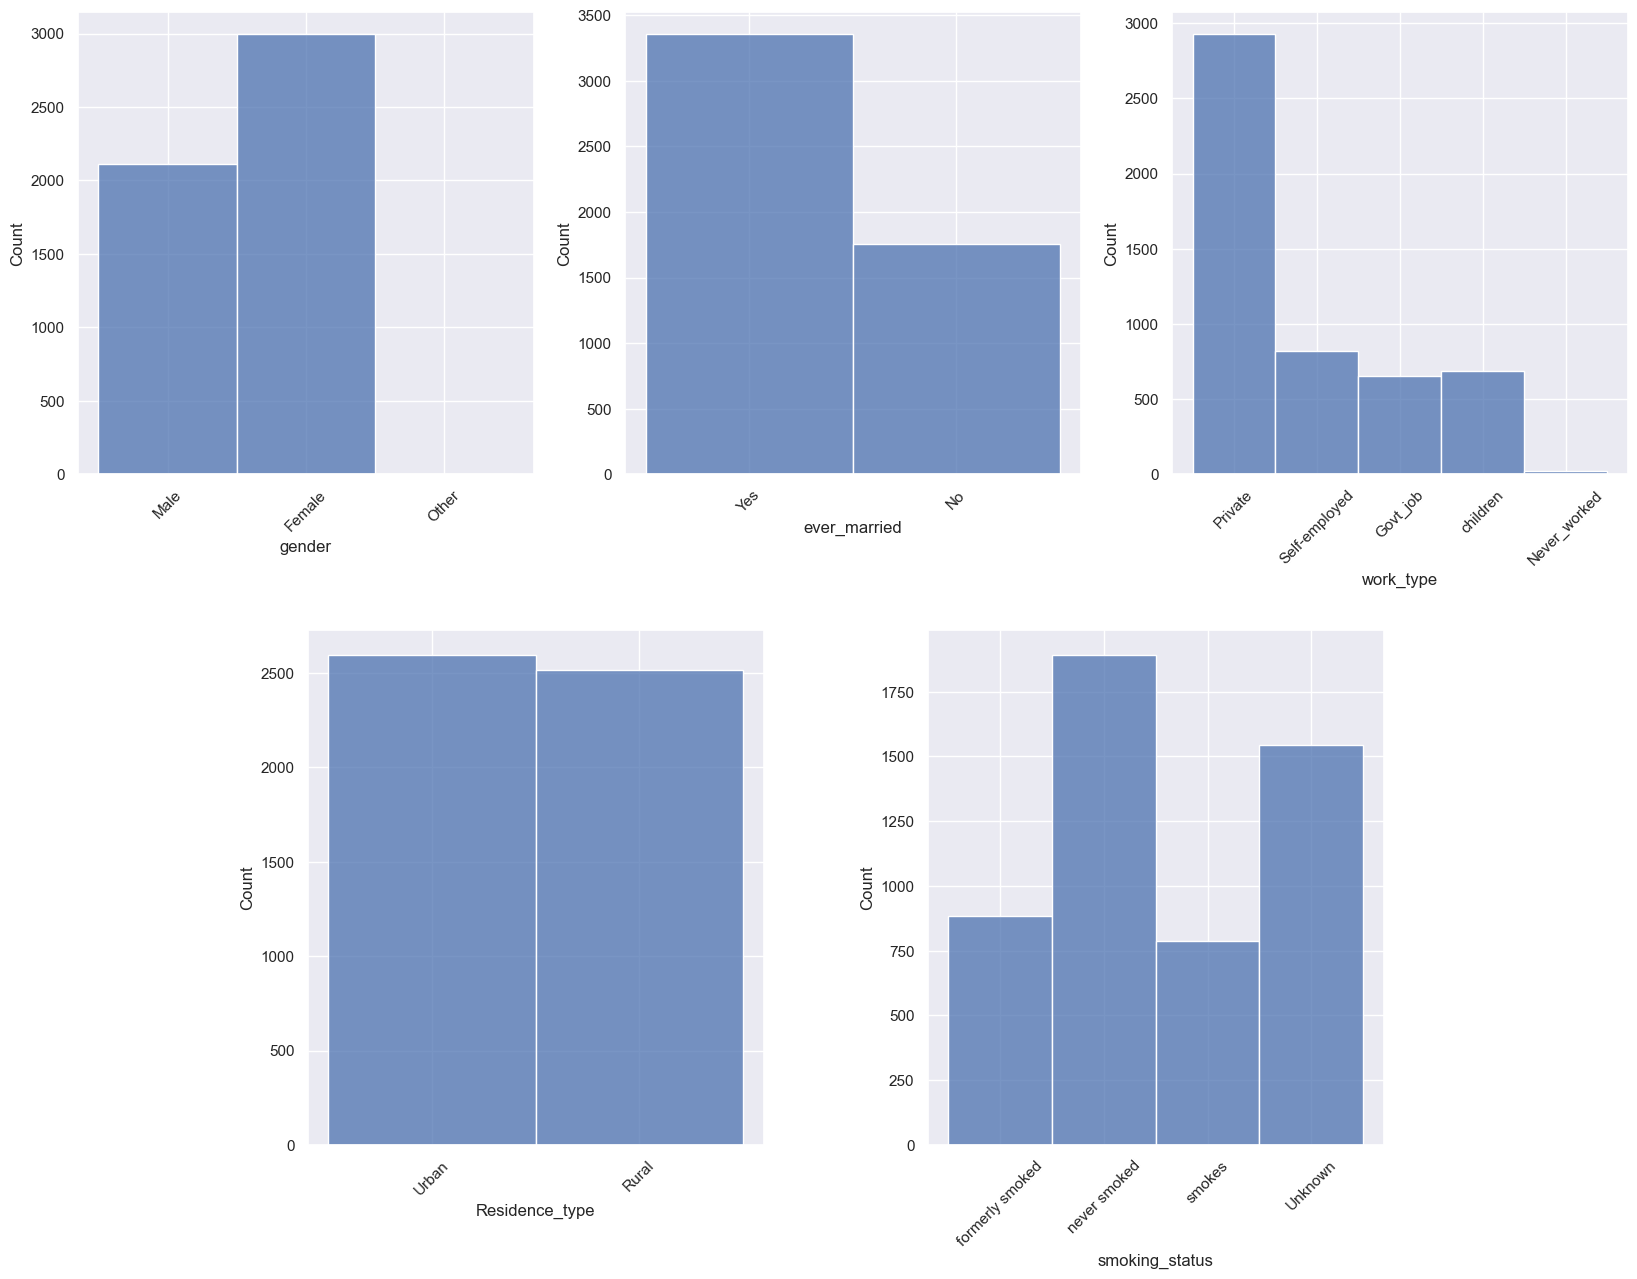

In [15]:
#Creating Subplot for features
fig, ax = plt.subplots(nrows = 2,              #Number of Rows
                         ncols = 3,            #Number of Columns
                         figsize = (20, 15))   #Size of each subplot


#Adding Gender subplot
sp1 = sns.histplot(ax = ax[0][0], data = ea_df, x = 'gender');

#Adding married subplot
sp2 = sns.histplot(ax = ax[0][1], data = ea_df, x = 'ever_married')

#Adding work type subplot
sp3 = sns.histplot(ax = ax[0][2], data = ea_df, x = 'work_type')

#Adding residence type subplot
sp4 = sns.histplot(ax = ax[1][0], data = ea_df, x = 'Residence_type')

#adding smoking status subplot
sp5 = sns.histplot(ax = ax[1][1], data = ea_df, x = 'smoking_status')


#Adding space between subplots for readability
fig.subplots_adjust(hspace = 0.5)

#Rotating tick labels for readability
sp1.set_xticklabels(sp1.get_xticklabels(),
                    rotation = 45);
sp2.set_xticklabels(sp2.get_xticklabels(),
                    rotation = 45);
sp3.set_xticklabels(sp3.get_xticklabels(),
                    rotation = 45);
sp4.set_xticklabels(sp4.get_xticklabels(),
                    rotation = 45);
sp5.set_xticklabels(sp5.get_xticklabels(),
                    rotation = 45);


#Since we only need 5 subplots, hiding 6th one
ax[1][2].set_visible(False)
#Moving bottom two subplots to be more centered for better viewing
ax[1][0].set_position([0.24, 0.125, 0.228, 0.343])
ax[1][1].set_position([0.55, 0.125, 0.228, 0.343])

- Code for the positioning of subplots 4 and 5 was taken from: https://stackoverflow.com/questions/26767281/position-5-subplots-in-matplotlib

- Gender
    - We have a fairly even split of male/female, with slightly more females.
- Ever Married
    - We have about double the amount of people who were married vs. not married.
- Job Type
    - Many of the responses chose to not disclose their job type
    - People who did respond have a very even split between self employed, government job, and stay-at-home parents, with a very small amount of people who have not worked.
- Residence Type
    - Very even split between urban and rural residence
- Smoking Status
    - About half of the people who responded to this have never smoked
    - The other half is fairly evenly split between currently smokes and formerly smokes

### Numerical Features

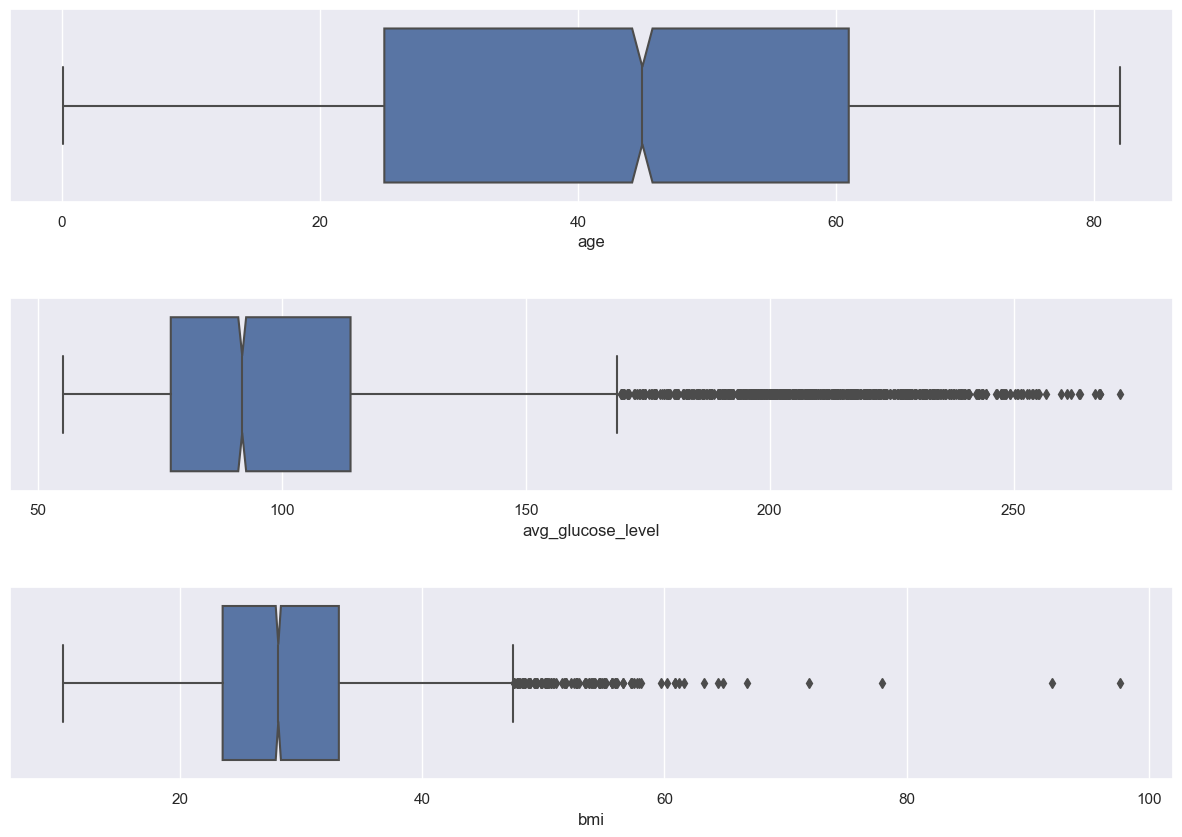

In [16]:
#Creating Subplot for features
fig, ax = plt.subplots(nrows = 3,            #Number of Rows
                       ncols = 1,            #Number of Columns
                       figsize = (15, 10))   #Size of each subplot

#Adjusting padding between the 3 subplots for readability
fig.subplots_adjust(hspace=0.5)


#Adding Age subplot
sns.boxplot(ax=ax[0], data=ea_df, x='age', notch=True);

#Adding avg Glucose Level subplot
sns.boxplot(ax=ax[1], data=ea_df, x='avg_glucose_level', notch=True);

#Adding bmi subplot
sns.boxplot(ax=ax[2], data=ea_df, x='bmi', notch=True);

- Age
    - Fairly even distribution, some very low values that may need to be looked at more
    - Could just be thorough sampling and including a very young baby
- Average Glucose Level
    - Majority of data lies between about 50 and 170
    - Quite a few outliers reaching over 250
    - Mean of around 90, 50% of the data between about 75 and 115
- BMI
    - Majority of data between about 5 and 50
    - Outliers for the most part are not much higher than the max of our boxplot
    - There are a few outliers up around 90 which may need to be addressed, might not be realistic value
    - Most of the data appears to be normal, with the average BMI in the high 20s

In [17]:
#Changing hypertension and heart disease responses from 1/0 to yes/no
ea_df['hypertension'] = ea_df['hypertension'].replace({0: "No",
                                                       1: "Yes"})
ea_df['heart_disease'] = ea_df['heart_disease'].replace({0: "No",
                                                         1: "Yes"})
ea_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


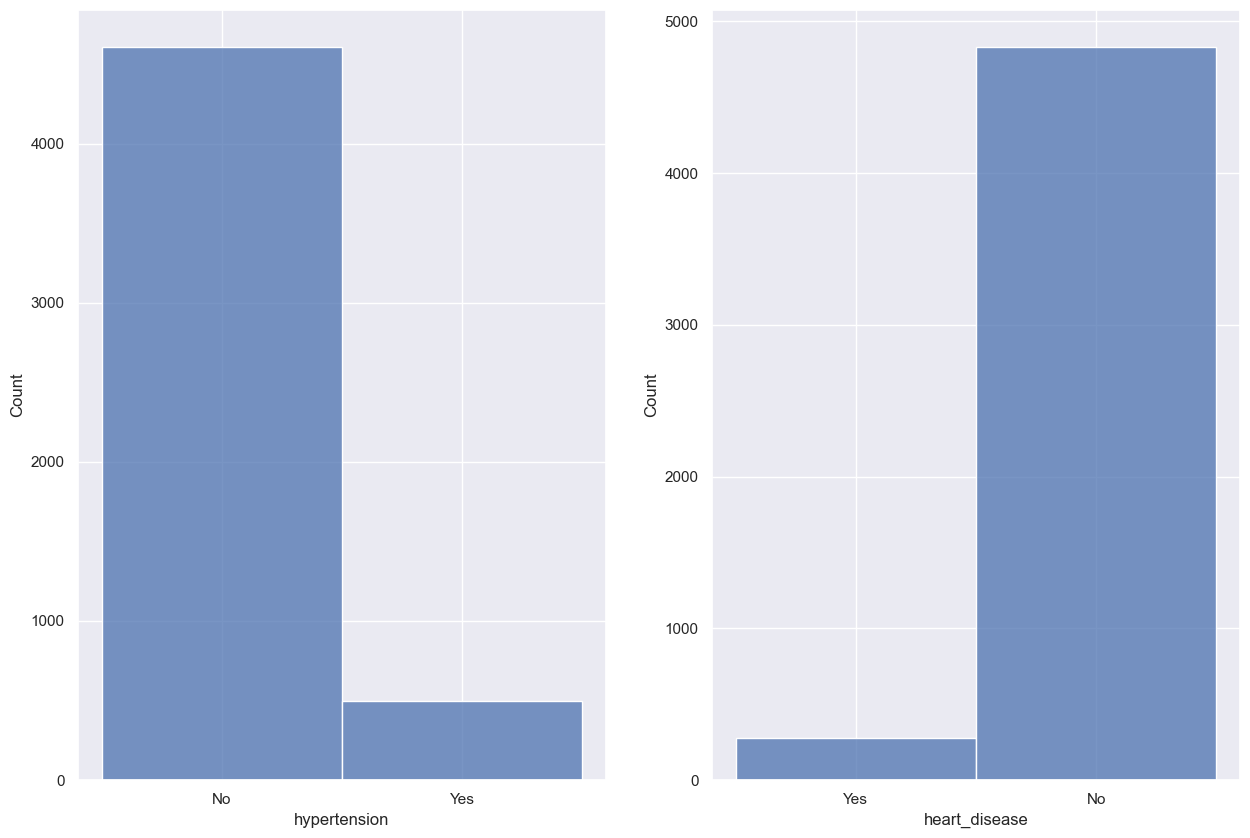

In [18]:
#Creating Subplot for features
fig, ax = plt.subplots(nrows = 1,            #Number of Rows
                       ncols = 2,            #Number of Columns
                       figsize = (15, 10))   #Size of each subplot

#Adding hypertension to subplots
sns.histplot(ax=ax[0], data=ea_df, x='hypertension');

#Adding heart disease to subplots
sns.histplot(ax=ax[1], data=ea_df, x='heart_disease');

- Hypertension
    - Majority of responses had no hypertension, may need to be considered during modeling later
- Heart Disease
    - Again, majority of responses had no history of heart disease. Also may need to be considered during modeling

### Target

In [19]:
#Changing 0's and 1's to "yes" or "no" for graphing
ea_df['stroke'] = ea_df['stroke'].replace({0: "No",
                                           1: "Yes"})

ea_df['stroke'].head()

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: stroke, dtype: object

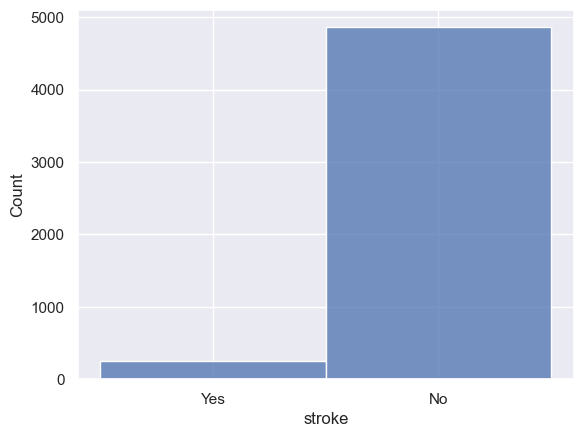

In [20]:
#Plotting
sns.histplot(data=ea_df, x='stroke');

- We can see the large majority of the people did not have a stroke
    - This will need to be taken into account during machine learning models

In [21]:
ea_df['stroke'].value_counts()

No     4861
Yes     249
Name: stroke, dtype: int64

### Multivariate Analysis


In [22]:
#Copying original dataframe
mv_df = df.copy()
mv_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [23]:
#Changing married column to 1 for yes, 0 for no
mv_df['ever_married'] = mv_df['ever_married'].replace({'Yes': 1,
                                                 'No': 0})

mv_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1


#### Heatmap for Correlations

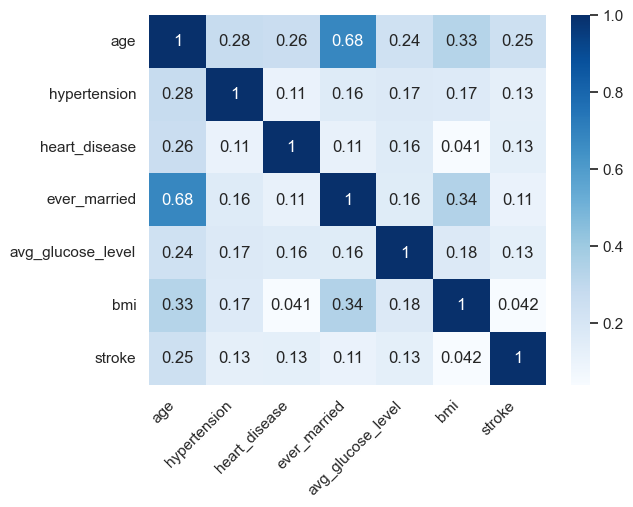

In [24]:
#Finding correlations between numerical variables
corr = mv_df[['age', 'hypertension', 'heart_disease', 'ever_married',
              'avg_glucose_level', 'bmi', 'stroke']].corr()

#Creating heatmap of correlations
sns.heatmap(corr, annot = True, cmap='Blues')

#rotating and shifting labels for readability
plt.xticks(rotation=45,ha = 'right');

- No large correlations between our target, stroke, and the other features of our data
    - Weak positive correlation between age and stroke
- Strong positive correlation between age and whether or not the person was married
- Weak positive correlation between age and bmi
- Weak positive correlation between bmi and if the person was married

#### Multivariate Visualizations

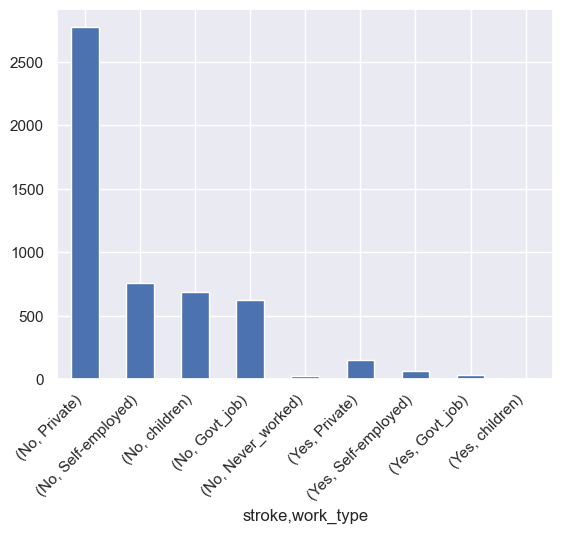

In [25]:
ea_df.groupby('stroke')['work_type'].value_counts().plot(kind='bar');
plt.xticks(rotation=45, ha='right');

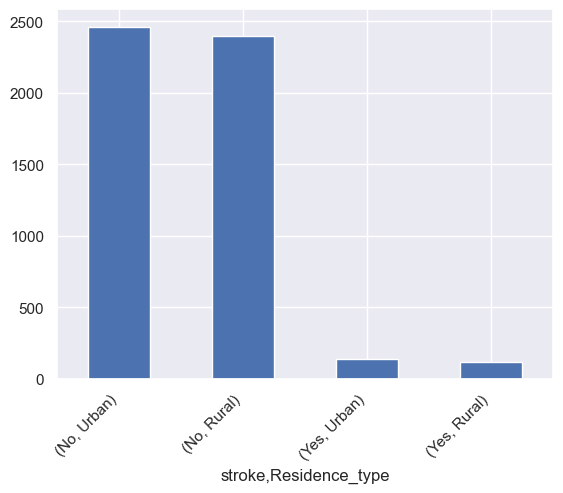

In [26]:
ea_df.groupby('stroke')['Residence_type'].value_counts().plot(kind='bar');
plt.xticks(rotation=45, ha='right');

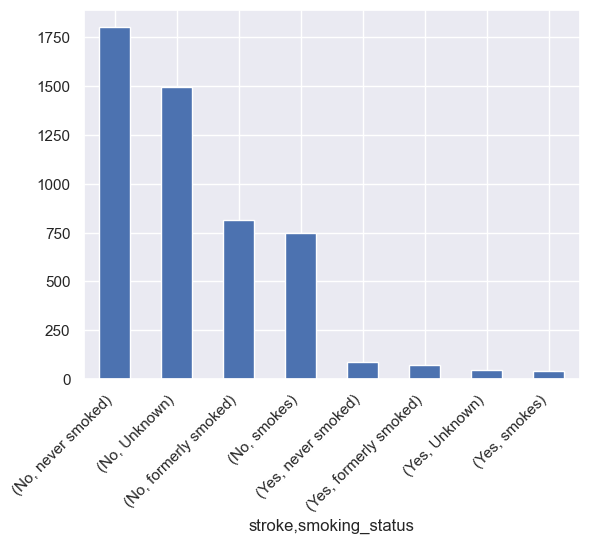

In [27]:
ea_df.groupby('stroke')['smoking_status'].value_counts().plot(kind='bar');
plt.xticks(rotation=45, ha='right');

- Work Type
    - People who recorded a "Private" work type tended to have the highest number of strokes, could be skewed because it is such a large range of jobs
    - Self-Employed people had a very small amount more strokes than people who worked a government job
    - People who worked with children recorded very little (2) strokes
- Residence Type
    - There seems to be extremely little if any correlation between residence type and whether or not the person had a stroke or not
    - Very even split between rural and urban
- Smoking Status
    - If we combine people who have or have previously smoked, there is a small amount more of these people who have had strokes versus non smokers

### Key Trends

#### Trend 1

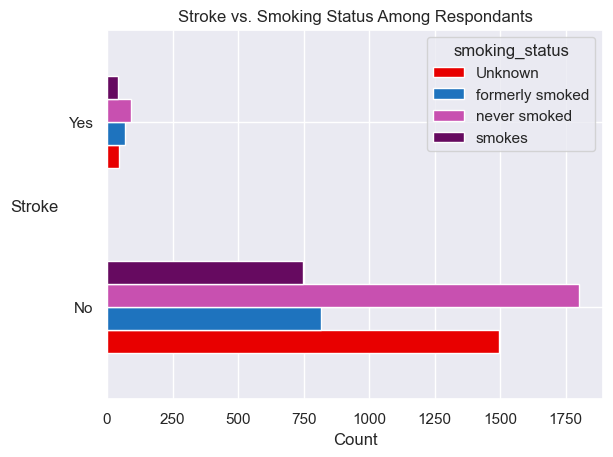

In [28]:
#Initial graph
ea_df.groupby('stroke')['smoking_status'].value_counts().unstack().plot(
                                kind='barh', color=['#E80000',    #Red
                                                    '#1E73BE',    #Blue
                                                    '#C850B0',    #Pinkish
                                                    '#660A60']);  #Purple
                                                    

#Adding label to x axis
plt.xlabel('Count');

#Rotating y label
plt.ylabel('Stroke', rotation=0, labelpad=25);

#Adding title
plt.title('Stroke vs. Smoking Status Among Respondants');

- People that have had a stroke are slightly more likely to currently or formerly smoke than non smokers.
- More non-smokers have not had strokes compared to current or former smokers.
- Unknown entries may swing the data more drastically in one direction, especially with the small amount of data we have for people who have had a stroke.

#### Trend 2

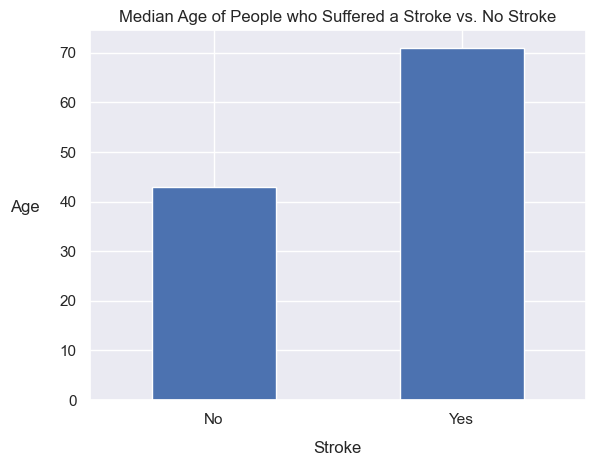

In [29]:
#Getting median value of age for both stroke categories
ea_df.groupby('stroke')['age'].median().plot(kind='bar')

#Making x label capitalized
plt.xlabel('Stroke', labelpad=10)
#Rotatingi x tick labels for readability
plt.xticks(rotation=0)

#Adding y label
plt.ylabel('Age', rotation=0, labelpad=25)

#Adding title
plt.title('Median Age of People who Suffered a Stroke vs. No Stroke');

- People who did not have a stroke have a fairly average age of just over 40.
- People who did have a stroke have a median age of just over 70.
- We can see the median age of people who have had a stroke is much higher, about 30 years, than people who have not had a stroke. 

## Machine Learning

### Preparing for Preprocessing

In [30]:
#Copying data to prevent leakage
ml_df = df.copy()
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [31]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


- Looks to have copied successfully 

- None of our data requires ordinal encoding so we can OneHotEncode all of our categorical data.
- Want to update a few columns from integer datatype to object because they do not need to be scaled (Hypertension, etc)

In [32]:
#Updating datatypes
ml_df['hypertension'] = ml_df['hypertension'].astype(object)
ml_df['heart_disease'] = ml_df['heart_disease'].astype(object)

ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   object 
 3   heart_disease      5110 non-null   object 
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 439.3+ KB


- Converted successfully

### Preprocessing

#### Defining Target and Features

In [33]:
target = 'stroke'
y = ml_df[target].copy()
X = ml_df.drop(columns = [target]).copy()

In [34]:
#X
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [35]:
#y
y.head()

0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: int64

- Looks to have split correctly

#### Splitting Data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### Column Selectors

In [37]:
#Numerical selector
num_selector = make_column_selector(dtype_include='number')

#Categorical selector
cat_selector = make_column_selector(dtype_include='object')

#### Transformers

In [38]:
#Instantiating Transformers, scaler for num, OHE for cat
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

#### Imputer

In [39]:
#Imputer for missing values in BMI column
mean_imputer = SimpleImputer(strategy='mean')

#### Numerical Pipeline

In [40]:
#Numerical pipe
num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [41]:
#Categorical pipe
cat_pipe = make_pipeline(ohe)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

#### Tuples

In [42]:
#Numerical tuple
num_tuple = (num_pipe, num_selector)

#Categorical tuple
cat_tuple = (cat_pipe, cat_selector)

- Do not need to make pipelines here because we do not need to impute any data, can skip ahead to the tuples for column transformer

#### Column Transformer

In [43]:
preprocessor = make_column_transformer(num_tuple,
                                       cat_tuple,
                                       remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])

### Models

#### Decision Tree

In [44]:
#Instantiate Decision Tree
dec_tree = DecisionTreeClassifier(random_state=42)

In [45]:
#Making pipeline for decisiontreeclassifier
dt_pipe = make_pipeline(preprocessor, dec_tree)
dt_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [46]:
#Getting parameters
dt_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
  ('decisiontreeclassifier', DecisionTreeClassifier(random_sta

In [47]:
#Decision Tree Hyperparameters to test with
dt_param = {'decisiontreeclassifier__max_depth': range(1, 10),
            'decisiontreeclassifier__min_samples_leaf': [1, 5, 10, 15, 20],
            'decisiontreeclassifier__min_samples_split': range(2, 11)}

In [48]:
#Tuning parameters
dt_pipe_gs = GridSearchCV(dt_pipe, dt_param)

In [49]:
#Fitting model
dt_pipe_gs.fit(X_train, y_train)

#Viewing best parameters
dt_pipe_gs.best_params_

{'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

In [50]:
#Seeing if we can tune this model a little better
dt_param2 = {'decisiontreeclassifier__max_depth': range(1, 5),
            'decisiontreeclassifier__min_samples_leaf': range(1, 5),
            'decisiontreeclassifier__min_samples_split': range(2, 5)}

In [51]:
#Searching for best combo
dt_gs2 = GridSearchCV(dt_pipe, dt_param2)

#Fitting model
dt_gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_un...nore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 5),
                         'decisiontreeclassifier__min_samples_leaf': range(1, 5),
                         'decisiontreeclassifier__min_samples_split': range(2, 5)})

In [52]:
#Getting best model
dt_best = dt_gs2.best_estimator_

#Fitting
dt_best.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026618C08EE0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026618C08910>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=1, random_state=42))])

In [53]:
#predicting model
dt_pred = dt_best.predict(X_test)

#Classification report
print(classification_report(y_test, dt_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.97      0.50      0.48      1278
weighted avg       0.94      0.94      0.91      1278



- This model has a testing accuracy of 94% after tuning

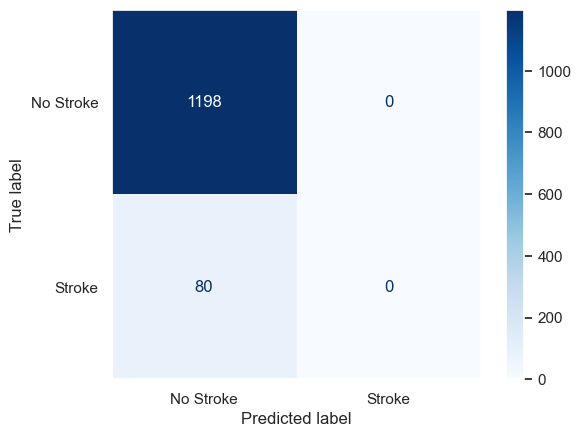

In [54]:
#Plotting confusion matrix
labels = ['No Stroke', 'Stroke']
ConfusionMatrixDisplay.from_predictions(y_test, dt_pred, display_labels=labels,
                                        cmap='Blues');
plt.grid(False)

- We can see from our confusion matrix that this model only predicts "no stroke".
- While this may result in high accuracy in the model, this is not ideal as we would prefer false positives to false negatives for this problem.

In [55]:
#Tuning the decision threshold

#Getting probability
dt_best_prob = dt_best.predict_proba(X_test)

# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)

# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []

# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(dt_best_prob, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))

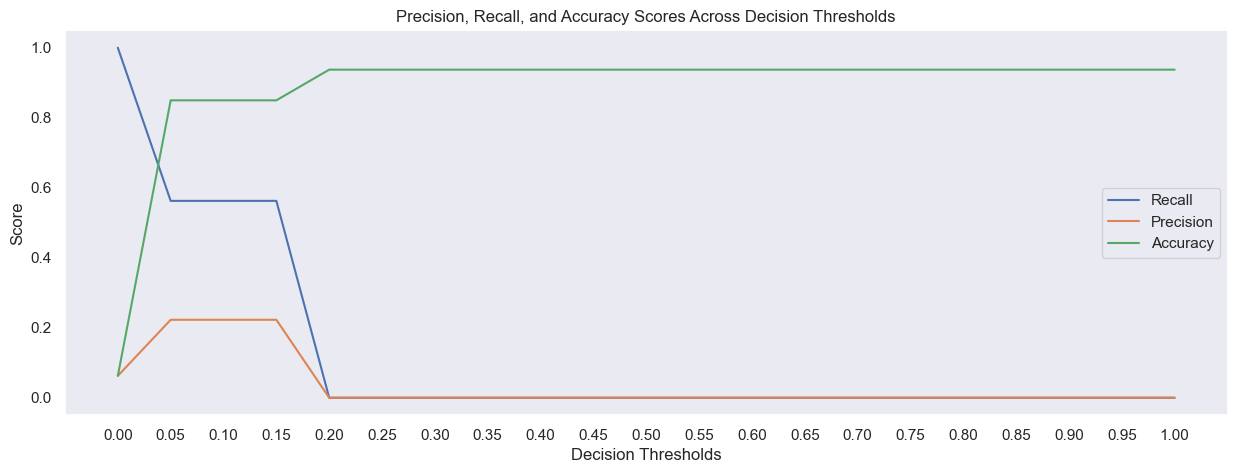

In [56]:
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show()

- Since we want a higher recall score to reduce false negatives, we will look at the model with a threshold between 0.05 and 0.15.
    - While a recall score of 0 is the highest, it would just make every prediction to be "yes" for stroke, which we also do not want

Decision Tree Train 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.96      0.93      3832



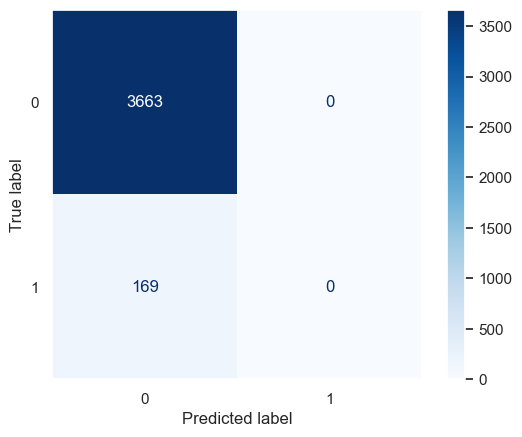

Decision Tree Test 

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1198
           1       0.22      0.56      0.32        80

    accuracy                           0.85      1278
   macro avg       0.60      0.72      0.62      1278
weighted avg       0.92      0.85      0.88      1278



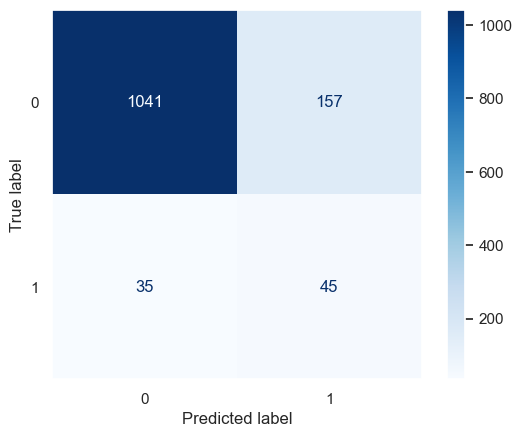

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Decision Tree Train,0.000000,0.0000,0.000000,0.955898
Decision Tree Test,0.222772,0.5625,0.319149,0.849765


In [57]:
#Convert probabilities with decision threshold of 0.1
dt_test_pred = convert_probs_to_preds(dt_best_prob, 0.1)
#Training scores
train_pred = dt_best.predict(X_train)

#Evaluate Model
train_scores = eval_classification(y_train, train_pred, name='Decision Tree Train')
test_scores = eval_classification(y_test, dt_test_pred, name='Decision Tree Test')

dt_scores = pd.concat([train_scores, test_scores])
dt_scores

- We managed to reduce the amount of type 2 errors by just over half with a decision threshold of 0.1.
- While this also increased the number of false positives, we would much rather have this than false negatives for this problem.

#### KNN

In [58]:
#Instantiate KNN
knn = KNeighborsClassifier()

In [59]:
#Making pipeline for KNN
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [60]:
#Getting parameters for this model
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose

In [61]:
#Selecting parameters to tune
knn_param = {'kneighborsclassifier__n_neighbors': range(1,10),
             'kneighborsclassifier__p': range(1,5),
             'kneighborsclassifier__weights': ['distance','uniform']}

In [62]:
#Tuning parameters
knn_pipe_gs = GridSearchCV(knn_pipe, knn_param)

In [63]:
#Fitting model
knn_pipe_gs.fit(X_train, y_train)

#Viewing best parameters
knn_pipe_gs.best_params_

{'kneighborsclassifier__n_neighbors': 4,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'uniform'}

- Best parameters are:
    - 4 n_neighbors
    - 1 p (power parameter)
    - Uniform weight

In [64]:
#Predicting model
knn_pred = knn_pipe_gs.predict(X_test)

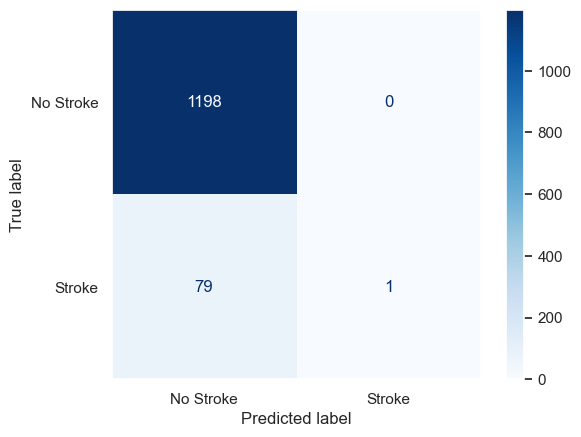

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



In [65]:
#Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred, 
                                        display_labels=labels,
                                        cmap='Blues');
plt.grid(False)
plt.show()

print(classification_report(y_test, knn_pred))

In [66]:
#Tuning the decision threshold

#Getting probability
knn_prob = knn_pipe_gs.predict_proba(X_test)

# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)

# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []

# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(knn_prob, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))

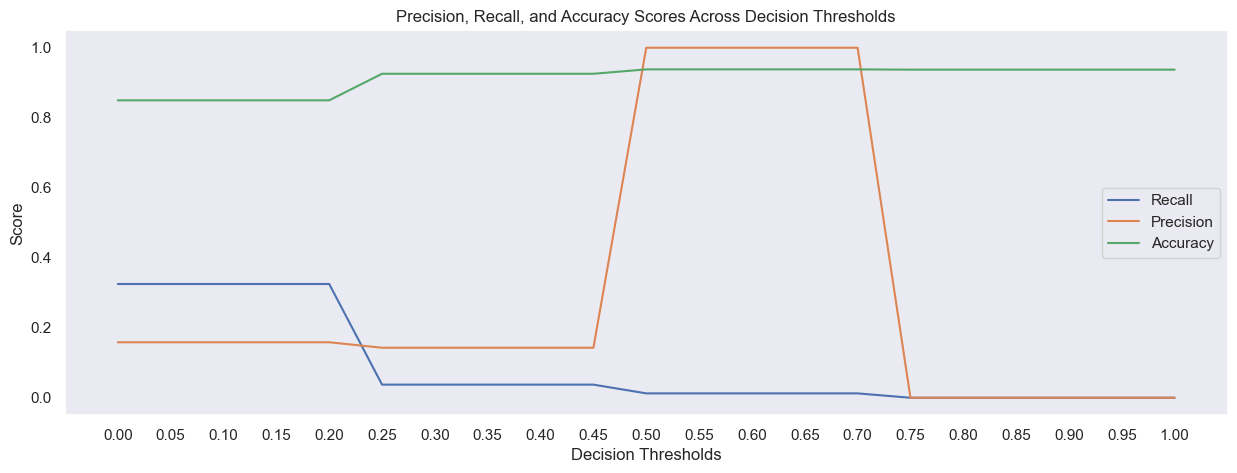

In [67]:
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show()

- Since we want a higher recall score to reduce false negatives, we will look at the model with a threshold between 0.05 and 0.2.
- We could technically look at a threshold of 0.0, but that would make every prediction return "yes" for stroke, which we also do not want.

KNN Train 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       1.00      0.04      0.07       169

    accuracy                           0.96      3832
   macro avg       0.98      0.52      0.52      3832
weighted avg       0.96      0.96      0.94      3832



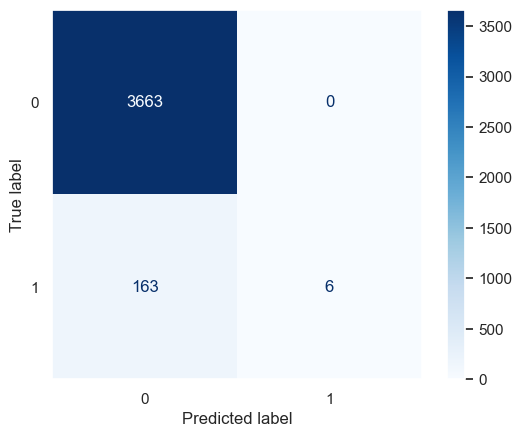

KNN Test 

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1198
           1       0.16      0.33      0.21        80

    accuracy                           0.85      1278
   macro avg       0.56      0.60      0.57      1278
weighted avg       0.90      0.85      0.87      1278



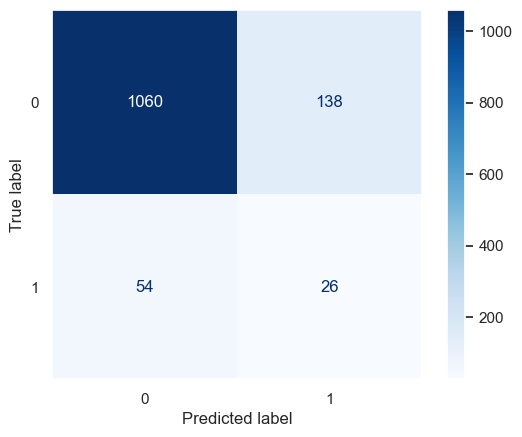

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
KNN Train,1.000000,0.035503,0.068571,0.957463
KNN Test,0.158537,0.325000,0.213115,0.849765


In [68]:
#Convert probabilities with a decision threshold of 0.15
knn_test_pred = convert_probs_to_preds(knn_prob, 0.15)

#Training Scores
train_pred = knn_pipe_gs.predict(X_train)

#Evaluate Model
train_scores1 = eval_classification(y_train, train_pred, name='KNN Train')
test_scores1 = eval_classification(y_test, knn_test_pred, name='KNN Test')

knn_scores = pd.concat([train_scores1, test_scores1])
knn_scores

- While we did reduce the number of type 1 errors, it was not as much as the decision tree model.

#### Random Forest

In [69]:
#Instantiate random forest
rf = RandomForestClassifier(random_state=42)

In [70]:
#Making pipeline for random forest
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [71]:
#Getting parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
  ('randomforestclassifier', RandomForestClassifier(random_sta

In [72]:
#Random Forest hyperparameters to test with
rf_param = {'randomforestclassifier__max_depth': range(1,10),
            'randomforestclassifier__min_samples_leaf': range(1,10),
            'randomforestclassifier__min_samples_split': range(2, 5),
            'randomforestclassifier__n_estimators': [1, 10, 20, 30, 40, 50]}

In [73]:
#Tuning parameters
rf_pipe_gs = GridSearchCV(rf_pipe, rf_param)

In [74]:
#Fitting model
rf_pipe_gs.fit(X_train, y_train)

#Viewing best parameters
rf_pipe_gs.best_params_

{'randomforestclassifier__max_depth': 6,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 10}

In [75]:
#Seeing if we can tune this model a little better
rf_param2 = {'randomforestclassifier__max_depth': range(3,8),
             'randomforestclassifier__min_samples_leaf': range(1,5),
             'randomforestclassifier__min_samples_split': range(2, 6),
             'randomforestclassifier__n_estimators': range(7, 14)}

In [76]:
#Searching for best combo
rf_gs2 = GridSearchCV(rf_pipe, rf_param2)

#Fitting
rf_gs2.fit(X_train, y_train)

#Viewing best parameters
rf_gs2.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 7}

- Best Parameters for Random Forest:
    - Max Depth of 5
    - Min Samples Leaf of 1
    - Min Samples Split of 5
    - Number Estimators of 7

In [77]:
#Getting best combo
rf_best = rf_gs2.best_estimator_

#Fitting
rf_best.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000266199BA9D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000266199BA880>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=5,
                                        n_estimators=7, random_state=42))])

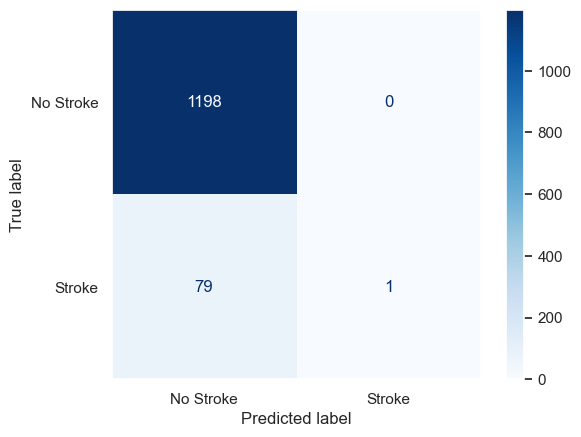

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



In [78]:
#Predicting Model
rf_pred = rf_best.predict(X_test)

#Plotting Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred,
                                        display_labels=labels,
                                        cmap='Blues')
plt.grid(False)
plt.show()

#Showing classification report
print(classification_report(y_test, rf_pred))

In [79]:
#Getting probability
rf_prob = rf_pipe_gs.predict_proba(X_test)

# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)

# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []

# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(rf_prob, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))

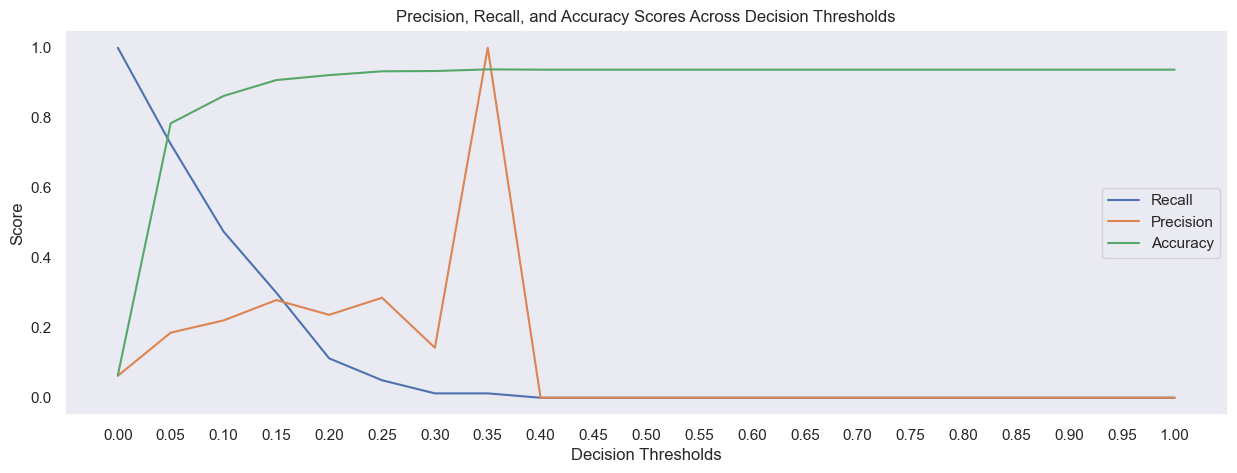

In [80]:
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show()

- We can see a threshold of around 0.05 yields the highest recall score which is what we are looking for

Random Forest Train 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.67      0.01      0.02       169

    accuracy                           0.96      3832
   macro avg       0.81      0.51      0.50      3832
weighted avg       0.94      0.96      0.94      3832



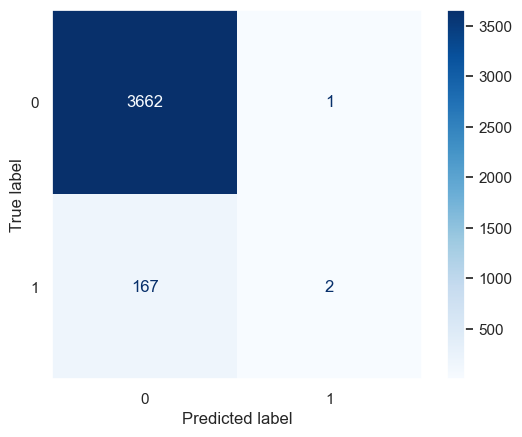

Random Forest Test 

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1198
           1       0.19      0.72      0.30        80

    accuracy                           0.78      1278
   macro avg       0.58      0.76      0.58      1278
weighted avg       0.93      0.78      0.84      1278



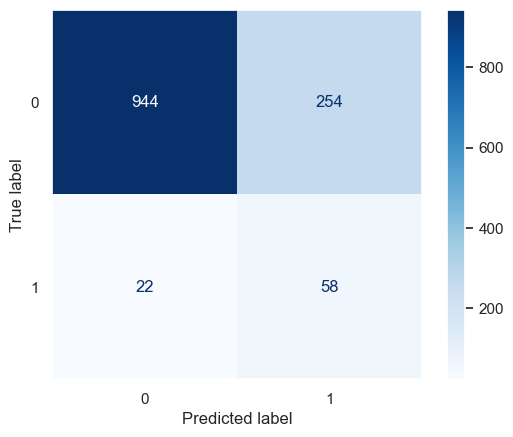

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Random Forest Train,0.666667,0.011834,0.023256,0.956159
Random Forest Test,0.185897,0.725000,0.295918,0.784038


In [81]:
#Convert probabilities with a decision threshold of 0.05
rf_test_pred = convert_probs_to_preds(rf_prob, 0.05)

#Training Scores
train_pred = rf_best.predict(X_train)

#Evaluate Model
train_scores2 = eval_classification(y_train, train_pred, name='Random Forest Train')
test_scores2 = eval_classification(y_test, rf_test_pred, name='Random Forest Test')

rf_scores = pd.concat([train_scores2, test_scores2])
rf_scores

- So far this model gives us the highest recall score and the highest accuracy of all our models.

#### Random Forest with PCA

In [82]:
#Instantiate PCA
pca = PCA(n_components = 0.95)

- Retaining 95% of the variance

In [83]:
#PCA Pipeline
pca_pipe = make_pipeline(preprocessor, pca)
pca_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                ('pca', PCA(n_components=0.95))])

In [84]:
#Random Forest with best params
rf_pca = RandomForestClassifier(max_depth=5,
                                min_samples_leaf=1,
                                min_samples_split=5,
                                n_estimators=7,
                                random_state=42)

#Create modeling pipeline
rf_pca_pipe = make_pipeline(pca_pipe, rf_pca)
rf_pca_pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                                 ('pca', PCA(n_components=0.95))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=5,
                                        n_estimators=7, random_state=42))])

In [85]:
#Fitting
rf_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                                 ('pca', PCA(n_components=0.95))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=5,
                                        n_estimators=7, random_state=42))])

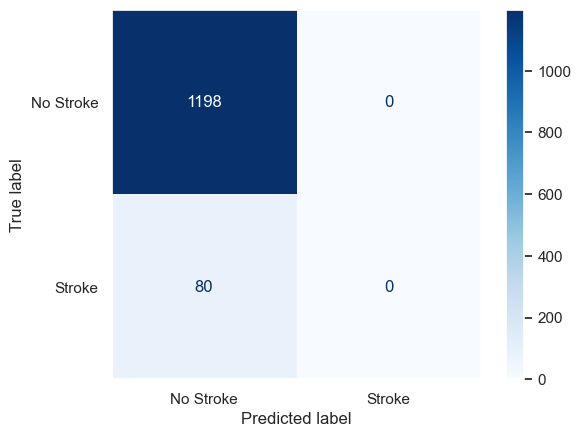

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



In [86]:
#Predicting Model
rf_pca_pred = rf_pca_pipe.predict(X_test)

#Plotting confusion matric
ConfusionMatrixDisplay.from_predictions(y_test, rf_pca_pred,
                                        display_labels=labels,
                                        cmap='Blues')
plt.grid(False)
plt.show()

#Showing classification report
print(classification_report(y_test, rf_pca_pred))

- This model will always predict 'No Stroke'
- While this yields a high accuracy score, we want to limit the amount of type 2 errors

In [87]:
#Getting probability
rf_pca_prob = rf_pca_pipe.predict_proba(X_test)

# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)

# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []

# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(rf_pca_prob, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))

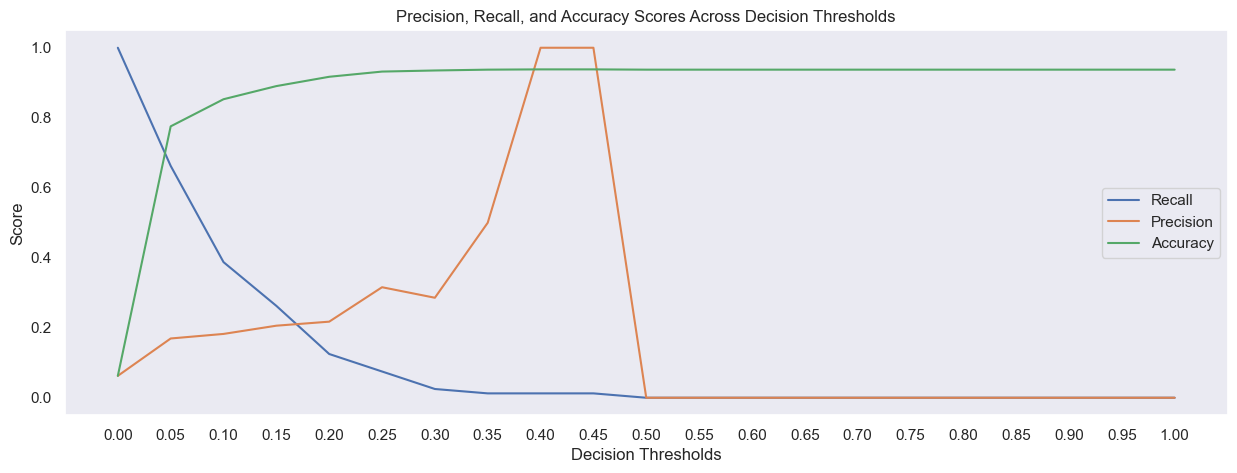

In [88]:
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show()

- Since we want the highest recall to reduce the amount of type 2 error, we will use a decision threshold of 0.05
- Could use a threshold of 0.0, but then our model would always predict "yes" for stroke, which would not be helpful to us.

Random Forest with PCA Train 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       1.00      0.02      0.03       169

    accuracy                           0.96      3832
   macro avg       0.98      0.51      0.51      3832
weighted avg       0.96      0.96      0.94      3832



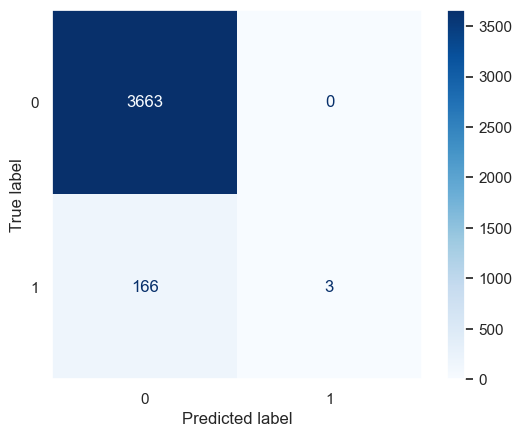

Random Forest with PCA Test 

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1198
           1       0.17      0.66      0.27        80

    accuracy                           0.78      1278
   macro avg       0.57      0.72      0.57      1278
weighted avg       0.92      0.78      0.83      1278



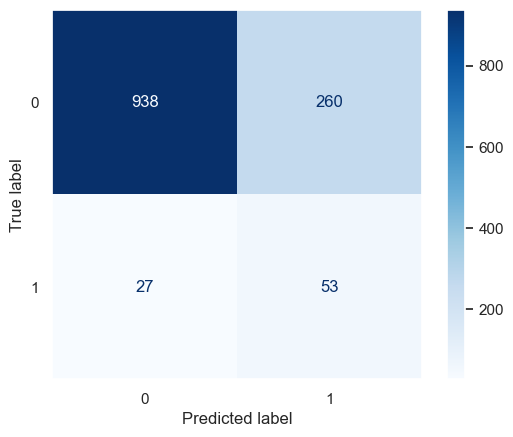

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Random Forest with PCA Train,1.000000,0.017751,0.034884,0.956681
Random Forest with PCA Test,0.169329,0.662500,0.269720,0.775430


In [89]:
#Convert probabilities with a decision threshold of 0.05
rf_test_pred = convert_probs_to_preds(rf_pca_prob, 0.05)

#Training Scores
train_pred = rf_pca_pipe.predict(X_train)

#Evaluate Model
train_scores3 = eval_classification(y_train, train_pred, name='Random Forest with PCA Train')
test_scores3 = eval_classification(y_test, rf_test_pred, name='Random Forest with PCA Test')

rf_pca_scores = pd.concat([train_scores3, test_scores3])
rf_pca_scores

- Recall score of 0.66 for our 'Stroke' column
- Still decent score, but not as high as our normal Random Forest model

#### KNN with PCA

- Instantiated PCA above as "pca", do not need to instantiate again
- PCA pipeline as "pca_pipe" above

In [90]:
#KNN model with best params
knn_pca = KNeighborsClassifier(n_neighbors=4,
                               p=1,
                               weights='uniform')

#Creating modeling pipeline
knn_pca_pipe = make_pipeline(pca_pipe, knn_pca)
knn_pca_pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                                 ('pca', PCA(n_components=0.95))])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=4, p=1))])

In [91]:
#Fitting
knn_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C483D0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000026611C3CEB0>)])),
                                 ('pca', PCA(n_components=0.95))])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=4, p=1))])

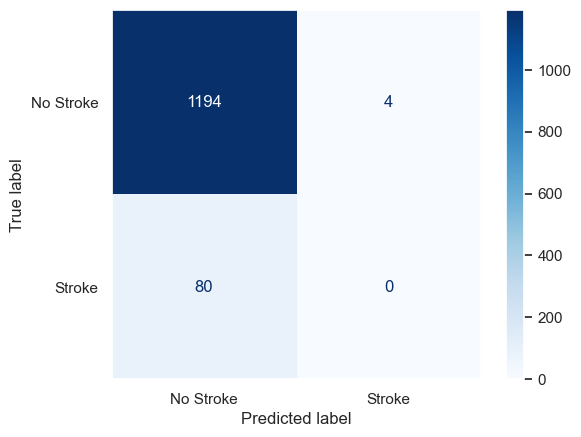

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.93      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.93      0.91      1278



In [92]:
#Predicting Model
knn_pca_pred = knn_pca_pipe.predict(X_test)

#Plotting confusion matric
ConfusionMatrixDisplay.from_predictions(y_test, knn_pca_pred,
                                        display_labels=labels,
                                        cmap='Blues')
plt.grid(False)
plt.show()

#Showing classification report
print(classification_report(y_test, knn_pca_pred))

- While there was a few data points that were predicted as "Stroke", the vast majority the model predicted "No Stroke"

In [93]:
#Getting probability
knn_pca_prob = knn_pca_pipe.predict_proba(X_test)

# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)

# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []

# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(knn_pca_prob, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))

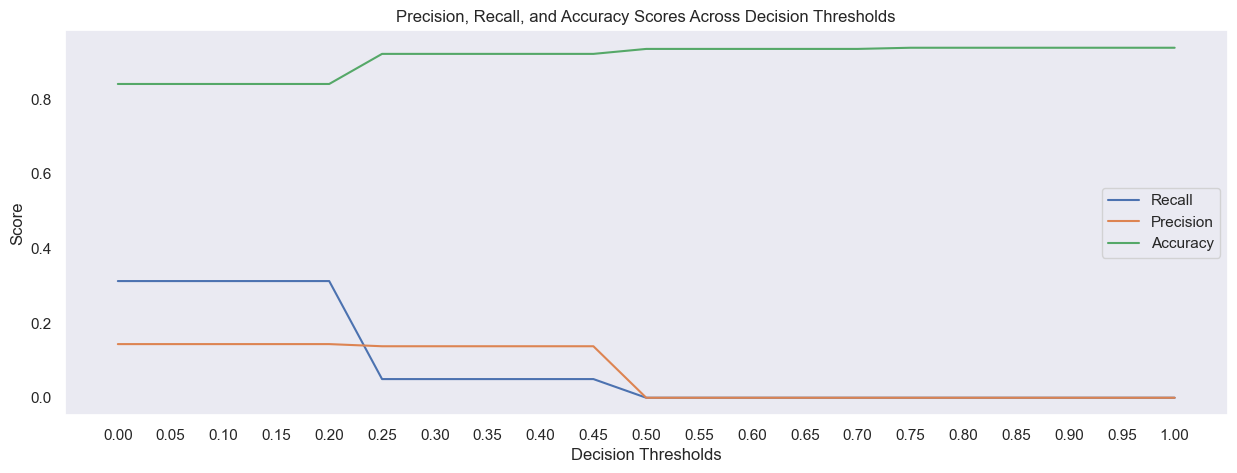

In [94]:
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show()

- No Recall score is particularly high, but a threshold of 0-0.2 yields the highest recall scores
- Again, we do not want to use a threshold of 0 because then our model will always predict "Stroke", which is not helpful

KNN with PCA Train 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       1.00      0.02      0.03       169

    accuracy                           0.96      3832
   macro avg       0.98      0.51      0.51      3832
weighted avg       0.96      0.96      0.94      3832



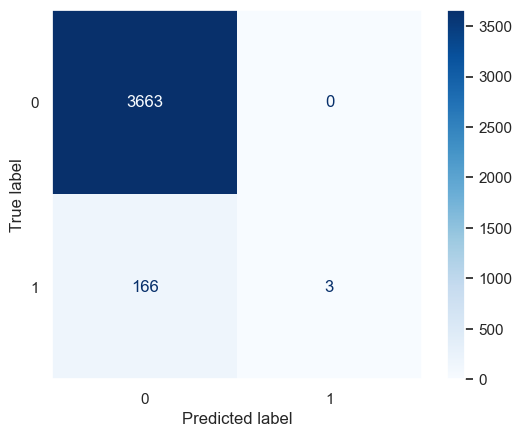

KNN with PCA Test 

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1198
           1       0.14      0.31      0.20        80

    accuracy                           0.84      1278
   macro avg       0.55      0.59      0.55      1278
weighted avg       0.90      0.84      0.87      1278



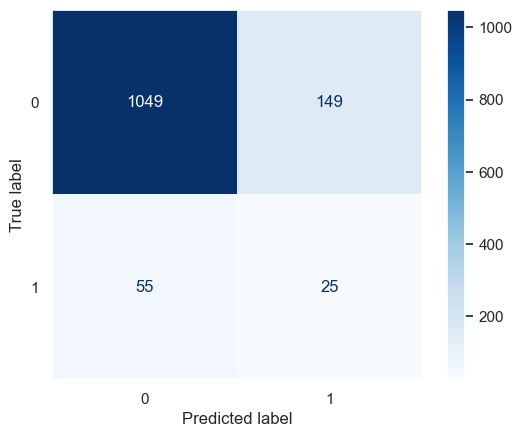

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
KNN with PCA Train,1.000000,0.017751,0.034884,0.956681
KNN with PCA Test,0.143678,0.312500,0.196850,0.840376


In [95]:
#Convert probabilities with a decision threshold of 0.1
knn_test_pred = convert_probs_to_preds(knn_pca_prob, 0.1)

#Training Scores
train_pred = rf_pca_pipe.predict(X_train)

#Evaluate Model
train_scores4 = eval_classification(y_train, train_pred, name='KNN with PCA Train')
test_scores4 = eval_classification(y_test, knn_test_pred, name='KNN with PCA Test')

knn_pca_scores = pd.concat([train_scores4, test_scores4])
knn_pca_scores

- While we increased our recall score from our default KNN with PCA model, this yields the same results as KNN without PCA.
- Both KNN models had a lower recall score than the Random Forest models.

## Model Recommendation 

In [96]:
scores = pd.concat([dt_scores, knn_scores, rf_scores, rf_pca_scores, knn_pca_scores])
scores

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Decision Tree Train,0.000000,0.000000,0.000000,0.955898
Decision Tree Test,0.222772,0.562500,0.319149,0.849765
KNN Train,1.000000,0.035503,0.068571,0.957463
KNN Test,0.158537,0.325000,0.213115,0.849765
Random Forest Train,0.666667,0.011834,0.023256,0.956159
Random Forest Test,0.185897,0.725000,0.295918,0.784038
Random Forest with PCA Train,1.000000,0.017751,0.034884,0.956681
Random Forest with PCA Test,0.169329,0.662500,0.269720,0.775430
KNN with PCA Train,1.000000,0.017751,0.034884,0.956681


- We want to minimize the amount of type two errors, so we will look for the model with the best recall score.
- We can see that the highest recall score is the Random Forest model with 72.5% recall.
- If we were to look at which model has the highest accuracy, we would use a KNN model. However, this doesnt take into account that the KNN model predicted the large majority of data to be "No Stroke", with a high amount of type 2 error which we do not want.

- Based on this information, a Random Forest model with the following parameters is recommended:
    - max_depth = 5
    - min_samples_leaf = 1
    - min_samples_split = 5
    - n_estimators = 7
    - Decision Threshold of 0.05